<a href="https://colab.research.google.com/github/viniciusrpb/cic0087_natural_language_processing/blob/main/cap4_2_sentiment_analysis_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 4 - Redes Neurais Recorrentes

## 4.3. Estudo de caso: Análise de Sentimentos utilizando uma Long Short Term Memory

### Tarefa: classificação de polaridade em tweets

Classificar um *tweet* em alguma das três polaridades: positiva (*positive*), negativa (*negative*) e positiva (*neutral*).

### O *corpus*

Para isso, vamos precisar utilizar as bibliotecas keras, tensorflow, numpy, sklearn, matplotlib.

Fonte: [SemEval-2013 Task 2: Sentiment Analysis in Twitter](https://aclanthology.org/S13-2052/)

O *corpus* de tweets empregado nesse estudo de caso podem ser acessados na pasta "corpus_tweets" deste repositório. Segue a especificação de cada arquivo:

*   ```twitter-2013train-A.txt```: conjunto de tweets para treinamento
*   ```twitter-2013dev-A.txt```: conjunto de tweets para validação
*   ```twitter-2013test-A.txt```: conjunto de tweets para testes

In [1]:
#!pip install -U keras
#!pip install -U tensorflow

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, Flatten, Embedding, SimpleRNN
from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from collections import Counter

### Carregamento do corpus para Pandas DataFrames



**PS.:** Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse [link](https://machinelearningmastery.com/difference-test-validation-datasets/).

In [3]:
path_train = 'twitter-2013train-A.txt'
path_valid = 'twitter-2013dev-A.txt'
path_test = 'twitter-2013test-A.txt'

In [4]:
df_train = pd.read_csv(path_train, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_valid = pd.read_csv(path_valid, names=["id","polarity","text"],encoding='utf8', sep='\t')
df_test = pd.read_csv(path_test, names=["id","polarity","text"],encoding='utf8', sep='\t')

df_train.head()

,id,polarity,text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [5]:
print(f"O conjunto de treinamento possui {df_train.shape[0]} tweets")
print(f"O conjunto de validação possui {df_valid.shape[0]} tweets")
print(f"O conjunto de testes possui {df_test.shape[0]} tweets")

O conjunto de treinamento possui 9684 tweets
O conjunto de validação possui 1654 tweets
O conjunto de testes possui 3547 tweets


Remove o atributo "id", uma vez que não precisaremos dele para a tarefa de classificação de polaridade de tweets.

In [6]:
df_train.drop(labels=['id'],axis=1)
df_valid.drop(labels=['id'],axis=1)
df_test.drop(labels=['id'],axis=1)

,polarity,text
0,positive,"@jjuueellzz down in the Atlantic city, ventnor..."
1,positive,Musical awareness: Great Big Beautiful Tomorro...
2,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,negative,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,neutral,"Excuse the connectivity of this live stream, f..."
...,...,...
3542,negative,Khaleda Zia's present India visit may have a b...
3543,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
3544,negative,@__Aniko you think mr.Calle let practice with ...
3545,positive,Don't hide under your desk! It's just a salsa ...


In [7]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
df_test['polarity'] = pd.Categorical(df_test['polarity'])

y_train = df_train['polarity'].cat.codes
y_valid = df_valid['polarity'].cat.codes
y_test = df_test['polarity'].cat.codes

In [8]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f'Valor original da classe {v} Transformação inteira: {y_train[i]}')

Valor original da classe positive Transformação inteira: 2
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe negative Transformação inteira: 0
Valor original da classe neutral Transformação inteira: 1


In [9]:
from keras.utils.np_utils import to_categorical

num_classes = 3

y_train_enc = to_categorical(y_train,3)
y_valid_enc = to_categorical(y_valid,3)
y_test_enc = to_categorical(y_test,3)

In [10]:
for i in range(0,5):
    v = df_train['polarity'][i]
    print(f"Tweet {i}: valor original da classe '{v}'; mapeamento para inteiro: {y_train[i]}; representação one-hot-encoding [{int(y_train_enc[i][0])},{int(y_train_enc[i][1])},{int(y_train_enc[i][2])}]")

Tweet 0: valor original da classe 'positive'; mapeamento para inteiro: 2; representação one-hot-encoding [0,0,1]
Tweet 1: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 2: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 3: valor original da classe 'negative'; mapeamento para inteiro: 0; representação one-hot-encoding [1,0,0]
Tweet 4: valor original da classe 'neutral'; mapeamento para inteiro: 1; representação one-hot-encoding [0,1,0]


### Extração de características dos tweets

Vamos tentar novamente. Dessa vez, vamos fazer um pré-processamento nos tweets que, certamente apresentam palavras que não acrescentam nada ao aprendizado do modelo, como:

*   @
*   URL
*   RT
*   Stopwords

Criando então as função para remover essas stopwords


In [11]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
import string 

def clean_stopwords_shortwords(w):
    
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_tweet(sentence):
    stopwords_list=stopwords.words('english')
    sentence = sentence.lower().strip()
    sentence = re.sub(r'^RT[\s]+', '', sentence)
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence)
    sentence = re.sub(r'#', '', sentence)
    sentence = re.sub(r'[0-9]', '', sentence)

    sentence_clean = ""

    for word in sentence.split():
        if (word not in stopwords_list):
            sentence_clean+=word+" "

    for c in string.punctuation:
        sentence_clean = sentence_clean.replace(c,"")
    return sentence_clean

def preprocess_tweets(X):

    df = []

    for string in X:
        ans = preprocess_tweet(string)
        df.append(ans)
    
    return pd.DataFrame(df,columns =['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df_train_proc = preprocess_tweets(df_train['text'])
df_valid_proc = preprocess_tweets(df_valid['text'])
df_test_proc = preprocess_tweets(df_test['text'])

In [13]:
print(f"Original tweet: {df_train['text'].iloc[0]}")
print(f"Preprocessed tweet: {df_train_proc['text'].iloc[0]}")

Original tweet: Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
Preprocessed tweet: gas house hit  ium going chapel hill sat  


In [14]:
results = Counter()
df_train_proc['text'].str.lower().str.split().apply(results.update)
df_valid_proc['text'].str.lower().str.split().apply(results.update)
df_test_proc['text'].str.lower().str.split().apply(results.update)
total_vocab_size = len(results)

In [15]:
def qtde_termos_tweet(df):
    soma = 0
    for item in df:
        soma += len(item)
    media = soma/len(df)
    print(f'Em média, cada tweets possui {media} palavras.')
    return int(media)

Hiperparâmetros

In [16]:
media = qtde_termos_tweet(df_train_proc['text'])

vocab_size = total_vocab_size
embedding_dim = media//2
max_length = media//2
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
bs=64

Em média, cada tweets possui 78.97614622057002 palavras.


In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train_proc['text'])

word_index = tokenizer.word_index
vocab_size = len(word_index)

In [18]:
train_sequences = tokenizer.texts_to_sequences(df_train_proc['text'])

valid_sequences = tokenizer.texts_to_sequences(df_valid_proc['text'])

test_sequences = tokenizer.texts_to_sequences(df_test_proc['text'])

X_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_valid = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Segue o modelo LSTM

In [19]:
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(vocab_size, output_dim=max_length, input_length=max_length))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 39)            920205    
                                                                 
 lstm (LSTM)                 (None, 32)                9216      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 929,520
Trainable params: 929,520
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
from tensorflow.keras.optimizers import SGD,Adam

opt = Adam(learning_rate=0.00001,decay=10-6)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [21]:
history = model.fit(X_train,y_train_enc,validation_data=(X_valid,y_valid_enc),epochs=10,batch_size=bs)

Epoch 1/10
152/152 [==============================] - 4s 9ms/step - loss: 1.0984 - accuracy: 0.3555 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 2/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0983 - accuracy: 0.3563 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 3/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0982 - accuracy: 0.3547 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 4/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0983 - accuracy: 0.3554 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 5/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0985 - accuracy: 0.3538 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 6/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0985 - accuracy: 0.3527 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 7/10
152/152 [==============================] - 1s 6ms/step - loss: 1.0984 - accuracy: 0.3534 - val_loss: 1.0989 - val_accuracy: 0.3476
Epoch 

In [22]:
import matplotlib.pyplot as plt

def plot_graphics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

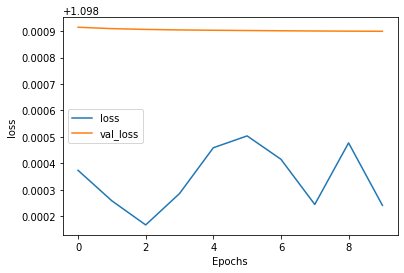

In [23]:
plot_graphics(history, 'loss')

In [24]:
# import classification_report
from sklearn.metrics import classification_report

_, test_acc = model.evaluate(X_test, y_test_enc, verbose=0)
print(test_acc)

y_pred = model.predict(X_test, batch_size=bs, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(y_pred, axis=-1)

# get the classification report
print(classification_report(y_test, y_pred))

0.4158443808555603
56/56 - 0s - 445ms/epoch - 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       559
           1       0.00      0.00      0.00      1513
           2       0.42      1.00      0.59      1475

    accuracy                           0.42      3547
   macro avg       0.14      0.33      0.20      3547
weighted avg       0.17      0.42      0.24      3547



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Veja que no exemplo acima, os tweets de teste foram classificados apenas como pertencentes a uma única classe. Isso era esperado com base nos resultados obtidos nos dados de validação durante o treinamento.

Caso você esteja enfrentando o mesmo comportamento acima, lembre-se sempre de analisar os valores da função *loss* que podem estar atingindo um mínimo local muito cedo. Você pode tentar as seguintes alternativas:


*   Pré-processamento dos dados: pode ser que os dados estejam poluídos, desbalanceados, ou apresentando redundância
*   Otimize os hiperparâmetros: tente variar a *learning rate* entre $[10^{-3},10^{-6}]$, como também o *batch size*
*   Deixe sua rede mais profunda, mas coloque camadas Dropout para evitar a ocorrência de *Overfitting*


### Modelo 2




Vamos tentar também novos hiperparâmetros:

In [45]:
model2 = Sequential()
model2.add(Embedding(vocab_size, output_dim=max_length, input_length=max_length))
model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes))
model2.add(Activation('sigmoid'))
print(model2.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 39, 39)            920205    
                                                                 
 lstm_7 (LSTM)               (None, 32)                9216      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
 activation_7 (Activation)   (None, 3)                 0         
                                                                 
Total params: 929,520
Trainable params: 929,520
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
opt = Adam(learning_rate=0.00001, decay=1e-6)
model2.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [47]:
history = model2.fit(X_train,y_train_enc,validation_data=(X_valid,y_valid_enc),epochs=80,batch_size=bs)

Epoch 1/80
152/152 [==============================] - 3s 8ms/step - loss: 1.0876 - accuracy: 0.4719 - val_loss: 1.0881 - val_accuracy: 0.4468
Epoch 2/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0815 - accuracy: 0.4729 - val_loss: 1.0838 - val_accuracy: 0.4468
Epoch 3/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0751 - accuracy: 0.4727 - val_loss: 1.0792 - val_accuracy: 0.4468
Epoch 4/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0678 - accuracy: 0.4732 - val_loss: 1.0742 - val_accuracy: 0.4468
Epoch 5/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0608 - accuracy: 0.4739 - val_loss: 1.0692 - val_accuracy: 0.4468
Epoch 6/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0524 - accuracy: 0.4734 - val_loss: 1.0641 - val_accuracy: 0.4468
Epoch 7/80
152/152 [==============================] - 1s 6ms/step - loss: 1.0439 - accuracy: 0.4736 - val_loss: 1.0594 - val_accuracy: 0.4468
Epoch 

In [48]:
# import classification_report
from sklearn.metrics import classification_report

_, test_acc = model2.evaluate(X_test, y_test_enc, verbose=2)
print(test_acc)

y_pred = model2.predict(X_test, batch_size=bs, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(y_pred, axis=-1)

# get the classification report
print(classification_report(y_test, y_pred))

111/111 - 0s - loss: 1.1590 - accuracy: 0.5489 - 326ms/epoch - 3ms/step
0.5489145517349243
56/56 - 0s - 422ms/epoch - 8ms/step
              precision    recall  f1-score   support

           0       0.59      0.03      0.05       559
           1       0.58      0.69      0.63      1513
           2       0.51      0.60      0.55      1475

    accuracy                           0.55      3547
   macro avg       0.56      0.44      0.41      3547
weighted avg       0.56      0.55      0.51      3547

